# Hate & Offensive Speech Detection in Social Media
### Okorie Okereke - 2114895

## 1. Introduction
Hate speech and offensive language detection on social media platforms has become increasingly important due to the rise of online conflicts (Watanabe, Bouazizi and Ohtsuki, 2018). Researchers have employed various machine learning and deep learning techniques to automatically identify such content (Abid Hussain Wani, Nahida Shafi Molvi and Sheikh Ishrah Ashraf, 2019; Davidson et al., 2017). This notebook presents a comparative analysis of different machine learning models for hate speech and offensive language detection on social media.

### 1.1. Dataset
The dataset is the [hate_speech_offensive](https://huggingface.co/datasets/tdavidson/hate_speech_offensive) consisting of 24,802 tweets. The dataset is divided into three classes: hate speech, offensive language, and neither. The dataset is imbalanced with 1,430 hate speech tweets, 19,190 offensive language tweets, and 4,182 neither tweets. The dataset is split into 80% training and 20% testing.

It's features are described as follows:
- `count`: number of crowd workers who coded each tweet (min is 3, sometimes more workers coded a tweet when judgments were determined to be unreliable by CF).
- `hate_speech_annotation`: number of crowd workers who judged the tweet to be hate speech.
- `offensive_language_annotation`: number of crowd workers who judged the tweet to be offensive.
- `neither_annotation`: number of crowd workers who judged the tweet to be neither offensive nor non-offensive.
- `class`: class label for majority of CF coders.
- `tweet`: text content of tweet.

The dataset will be used to train three models: a scaler vector machine (SVM), a random forest classifier, and a neural network. The models will be evaluated based on metrics such as accuracy, precision, recall, and F1 score.

In [3]:
from datasets import load_dataset

ds = load_dataset("tdavidson/hate_speech_offensive")

In [4]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet'],
        num_rows: 24783
    })
})


In [5]:
train = ds['train']
print(train.features.keys())

dict_keys(['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet'])


In [6]:
# print the first example in the training set
for k, v in train[0].items():
    print(f"{k}: {v}")

count: 3
hate_speech_count: 0
offensive_language_count: 0
neither_count: 3
class: 2
tweet: !!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...


In [7]:
import pandas as pd

df = pd.DataFrame(train)
df.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [8]:
print(f"Dataframe has {df.shape[0]} rows and {df.shape[1]} columns")

Dataframe has 24783 rows and 6 columns


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   count                     24783 non-null  int64 
 1   hate_speech_count         24783 non-null  int64 
 2   offensive_language_count  24783 non-null  int64 
 3   neither_count             24783 non-null  int64 
 4   class                     24783 non-null  int64 
 5   tweet                     24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB


In [10]:
df.isnull().sum()

count                       0
hate_speech_count           0
offensive_language_count    0
neither_count               0
class                       0
tweet                       0
dtype: int64

In [11]:
# Class Distribution
df['class'].value_counts()


class
1    19190
2     4163
0     1430
Name: count, dtype: int64

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

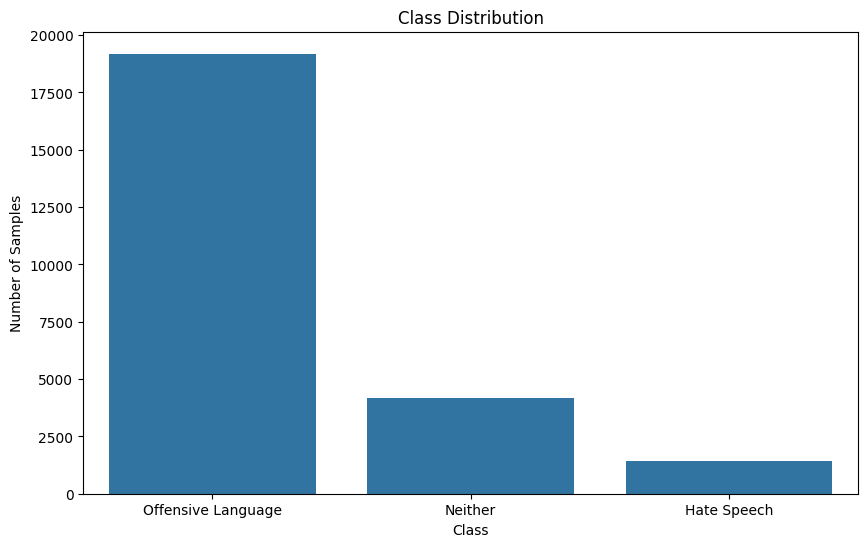

In [13]:
# get the class distribution
class_distribution = df['class'].value_counts()

# rename the index values
class_distribution = class_distribution.rename({0: 'Hate Speech', 1: 'Offensive Language', 2: 'Neither'})

# plot the class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Class Distribution')
plt.ylabel('Number of Samples')
plt.xlabel('Class')


# 0- Hate Speech, 1- Offensive Language, 2- Neither

plt.show()

A large majority of the tweets are offensive language, with a few hate speech tweets and neither tweets. The dataset is imbalanced, with the majority of the tweets being offensive language. The dataset is split into 80% training and 20% testing. Techniques such as k-fold cross-validation and class weight adjustments will be used to handle the imbalanced dataset.

### 1.2. Preprocessing
The preprocessing steps will be as follows:
- Tokenization: The tweets will be tokenized into words.
- Removing stopwords: Common stopwords will be removed.
- Lemmatization: Words will be lemmatized to their root form. This was chosen in place of stemming due to the nature of social media text. Lemmatization is more accurate than stemming as it uses a vocabulary and morphological analysis of words.
  

In [14]:
# Text Preprocessing
import re
import string
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

In [15]:
# download the stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
# create a function to preprocess the text
def preprocess_text(text):
    # convert text to lowercase
    text = text.lower()
    # remove numbers
    text = re.sub(r'\d+', '', text)#
    # remove @mentions
    text = re.sub(r'@\S+', '', text)
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove rt (retweet)
    text = re.sub(r'\brt\b', '', text)
    # remove social media links
    text = re.sub(r'http\S+', '', text)
    # remove whitespaces
    text = text.strip()
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    # tokenize the text
    tokens = word_tokenize(text)
    # remove stopwords
    text = [i for i in tokens if not i in stop_words]

    # lemmatization - convert the word into its root form
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]

    # join the words back into a single string
    text = ' '.join(text)

    return text

In [17]:
# test train split
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df['tweet'], df['class'], test_size=0.2, random_state=42)

In [19]:
print(X_train[0])
print(y_train[0])

!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
2


In [20]:
# preprocess the text
X_prep = X_train.apply(preprocess_text)

In [21]:
print(X_prep[0])

woman shouldnt complain cleaning house amp man always take trash


In [22]:
for tweet in X_train[:5]:
    print(tweet)

RT @FunSizedYogi: @TheBlackVoice well how else will white ppl get us to forget our horrific past other than to paint a pretty picture of ho&#8230;
Funny thing is....it's not just the people doing it. It's the people who seeing these pics and judging the birds. Just as wrong.
RT @winkSOSA: "@AintShitSweet__: "@Rakwon_OGOD: Nigga messed with the wrong bitch &#128557;&#128514;https://t.co/5mNXKVAYot" &#128557;&#128557;&#128557;&#128557;&#128514;&#128514;&#128557;&#128557;&#128514;&#128514;&#128514;&#128514;&#128514;&#128514;&#128514;"@Th_Real_Esco
@Jbrendaro30 @ZGabrail @ramsin1995 @GabeEli8 @Jacob2times bitch ass nigggaaa
S/o that real bitch


In [23]:
for tweet in X_prep[:5]:
    print(tweet)

well else white ppl get u forget horrific past paint pretty picture ho
funny thing isits people people seeing pic judging bird wrong
nigga messed wrong bitch
bitch as nigggaaa
real bitch


## 2. Representation Learning
Transformers, specifically the DistilBERT model, will be used to convert the tweets into numerical vectors. DistilBERT is a compressed version of BERT that retains 97% of its language understanding capabilities while being 40% smaller and 60% faster (Sanh et al., 2020). The DistilBERT model will be fine-tuned on the hate speech and offensive language dataset to generate embeddings for the tweets. The embeddings will be used as input features for the machine learning models.

In [24]:
from transformers import AutoTokenizer, AutoModel # we use the huggingface transformers library
import torch # the main pytorch library

In [ ]:
# load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased") 
# load the model
model = AutoModel.from_pretrained("distilbert-base-uncased")

In [26]:
#Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model =  model.to(device)

In [27]:
# batch encode the text
batch_size = 32
embeddings = []

In [28]:
def get_embeddings(texts, tokenizer, model, device, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size].tolist()
        # encode the batch of texts
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=128).to(device)
        # get the embeddings
        with torch.no_grad():
            output = model(**inputs)
        # we only need the output of the [CLS] token
        batch_embeddings = output.last_hidden_state[:, 0, :].cpu().numpy()
        # add the embeddings to the list
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

In [29]:
import os

if os.path.exists('tweet_embeddings.npy'):
    tweet_embeddings = np.load('tweet_embeddings.npy')
else:
    tweet_embeddings = get_embeddings(X_prep, tokenizer, model, device, batch_size)
    np.save('tweet_embeddings.npy', tweet_embeddings)

To save time, the DistilBERT model will be fine-tuned on the dataset and the embeddings will be saved. The embeddings will be loaded into the notebook for training the machine learning models.

In [30]:
print(tweet_embeddings.shape)

(19826, 768)


## 3. Machine Learning Models
SVM, Random Forest, and the LSTM neural network will be trained on the dataset. The models will be evaluated based on metrics such as accuracy, precision, recall, and F1 score. The best model will be selected based on the evaluation metrics.

- SVM: A linear SVM will be trained on the dataset. The SVM model will be trained using the embeddings generated by the DistilBERT model.
- Random Forest: A random forest classifier will be trained on the dataset. The random forest model will be trained using the embeddings generated by the DistilBERT model.
- LSTM: A long short-term memory (LSTM) neural network will be trained on the dataset. The LSTM model will be trained using the embeddings generated by the DistilBERT model. Improvements such as dropout and bidirectional LSTM will be used to enhance the model's performance.

In [32]:
from sklearn.manifold import TSNE # we use t-SNE for dimensionality reduction
from sklearn.svm import LinearSVC # we use SVM for classification
from sklearn.ensemble import RandomForestClassifier # we use Random Forest for classification
from sklearn.model_selection import StratifiedKFold # we use stratified k-fold cross-validation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tqdm import tqdm

### 3.1. Improvement: tSNE Visualization
t-distributed Stochastic Neighbor Embedding (t-SNE) is a powerful dimensionality reduction and visualization technique for high-dimensional data. The t-SNE algorithm will be used to visualize the embeddings generated by the DistilBERT model. The embeddings will be reduced to two dimensions and plotted to visualize the distribution of the tweets in the dataset.

In [33]:
# Apply t-SNE to reduce the dimensionality of the embeddings; this will make it easier to visualize the embeddings
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(tweet_embeddings)

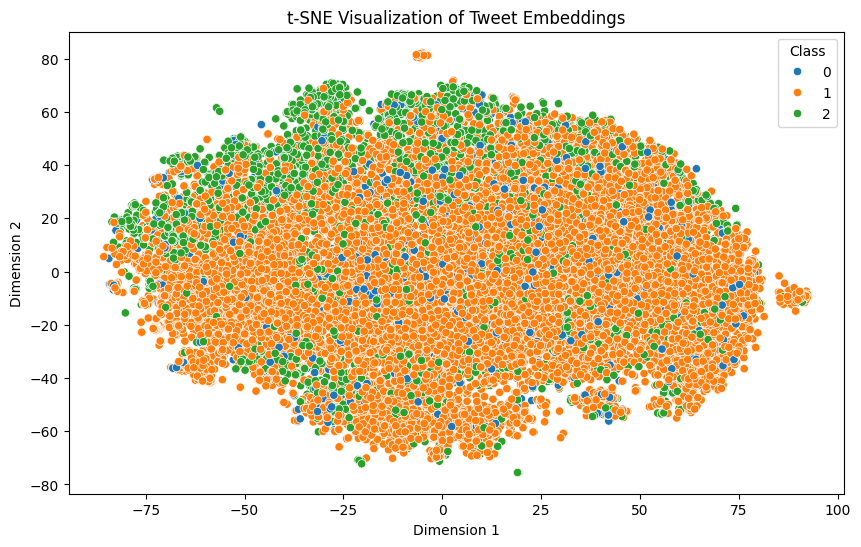

In [34]:
# plot the reduced embeddings
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=y_train, palette='tab10')
plt.title('t-SNE Visualization of Tweet Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Class', loc='upper right')
plt.show()

In [35]:
X_test_prep = X_test.apply(preprocess_text)

In [36]:
# transform the test data
if os.path.exists('test_embeddings.npy'):
    test_embeddings = np.load('test_embeddings.npy')
else:
    test_embeddings = get_embeddings(X_test_prep, tokenizer, model, device, batch_size)
    np.save('test_embeddings.npy', test_embeddings)

In [37]:
X_test_reduced = tsne.fit_transform(test_embeddings)

### 3.2. k-fold Cross-Validation
k-fold cross-validation will be used to evaluate the models. The dataset will be split into k-folds, and each fold will be used as a validation set while the rest of the folds will be used for training. The models will be evaluated on each fold, and the average performance will be reported.

In [38]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

# Function to train and evaluate the model using k-fold cross-validation
def train_evaluate_model(X, y, model, kf):
    accuracy_scores = []

    # Loop through each fold
    for train_index, val_index in tqdm(kf.split(X, y), total=kf.get_n_splits(), desc="K-Fold Progress"):
        # Split the data
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_val)

        # Evaluate and record accuracy
        accuracy = accuracy_score(y_val, y_pred)
        accuracy_scores.append(accuracy)

    # Return accuracy scores and summary statistics
    return {
        "accuracy_scores": accuracy_scores,
        "mean_accuracy": np.mean(accuracy_scores),
        "std_accuracy": np.std(accuracy_scores),
    }


In [39]:
# train and evaluate the SVM model
svm = LinearSVC()

# reset indices
y_train_reset = y_train.reset_index(drop=True)

svm_results = train_evaluate_model(tweet_embeddings, y_train_reset, svm, kf)


K-Fold Progress:   0%|          | 0/5 [00:00<?, ?it/s]

K-Fold Progress: 100%|██████████| 5/5 [01:10<00:00, 14.11s/it]


In [40]:
for result in svm_results:
    print(f"{result}: {svm_results[result]}")

accuracy_scores: [0.8663640948058497, 0.8711223203026481, 0.8716267339218159, 0.8670870113493064, 0.8680958385876418]
mean_accuracy: 0.8688591997934523
std_accuracy: 0.002132129484907504


In [41]:
# Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=50)

rf_results = train_evaluate_model(tweet_embeddings, y_train_reset, rf, kf)

K-Fold Progress: 100%|██████████| 5/5 [04:05<00:00, 49.12s/it]


In [42]:
for result in rf_results:
    print(f"{result}: {rf_results[result]}")

accuracy_scores: [0.8388804841149773, 0.8448928121059268, 0.8274905422446406, 0.8340479192938209, 0.8388398486759142]
mean_accuracy: 0.8368303212870559
std_accuracy: 0.00580031653558732


In [77]:
# classification report
def classification_report_kfold(X, y, model, kf):
    reports = []

    for train_index, val_index in tqdm(kf.split(X, y), total=kf.get_n_splits(), desc="K-Fold Progress"):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        report = classification_report(y_val, y_pred, target_names=['Hate Speech', 'Offensive Language', 'Neither'], output_dict=True)
        reports.append(report)

    return reports

In [ ]:
svm_reports = classification_report_kfold(tweet_embeddings, y_train_reset, svm, kf)

K-Fold Progress: 100%|██████████| 5/5 [01:09<00:00, 13.87s/it]


In [80]:
# print the classification report in a readable format
for i, report in enumerate(svm_reports):
    # write the classification report to a file
    with open("svm_classification_reports.txt", "w") as f:
        for i, report in enumerate(svm_reports):
            f.write(f"Fold {i+1}\n")
            f.write(pd.DataFrame(report).transpose().to_string())
            f.write("\n\n")

In [81]:
rf_reports = classification_report_kfold(tweet_embeddings, y_train_reset, rf, kf)

K-Fold Progress: 100%|██████████| 5/5 [03:50<00:00, 46.05s/it]


In [82]:
# write the classification report to a file
with open("rf_classification_reports.txt", "w") as f:
    for i, report in enumerate(rf_reports):
        f.write(f"Fold {i+1}\n")
        f.write(pd.DataFrame(report).transpose().to_string())
        f.write("\n\n")

### 3.3. Improvement: BiDirectionality, Dropout, Dense Layer, Adam Optimizer
The LSTM model will be improved by adding a bidirectional LSTM layer, dropout layers, a dense layer, and using the Adam optimizer. 
- The bidirectional LSTM layer will allow the model to learn from the input sequence in both forward and backward directions. 
- Dropout layers will help prevent overfitting by randomly setting a fraction of input units to zero during training. 
- A dense layer will be added to the model to map the LSTM output to the number of classes. The Adam optimizer will be used to optimize the model's weights.

In [45]:
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.optimizers import Adam

In [54]:
X = np.expand_dims(tweet_embeddings, axis=1) # add an extra dimension for the channel
y = np.array(y_train)

In [55]:
print(X.shape)

(19826, 1, 768)


In [56]:
def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.5))
    model.add(
        Dense(64, activation="relu")
    )  # An intermediate dense layer for better learning
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.001),
        metrics=["accuracy"],
    )
    return model

In [57]:
lstm_model = create_lstm_model((X.shape[1], X.shape[2]), len(np.unique(y)))

In [58]:
lstm_model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
496/496 [==============================] - 18s 20ms/step - loss: 0.5164 - accuracy: 0.8226 - val_loss: 0.4111 - val_accuracy: 0.8464
Epoch 2/10
496/496 [==============================] - 9s 18ms/step - loss: 0.4467 - accuracy: 0.8422 - val_loss: 0.3738 - val_accuracy: 0.8649
Epoch 3/10
496/496 [==============================] - 8s 17ms/step - loss: 0.4250 - accuracy: 0.8492 - val_loss: 0.3641 - val_accuracy: 0.8674
Epoch 4/10
496/496 [==============================] - 8s 17ms/step - loss: 0.4090 - accuracy: 0.8540 - val_loss: 0.3611 - val_accuracy: 0.8684
Epoch 5/10
496/496 [==============================] - 9s 17ms/step - loss: 0.3975 - accuracy: 0.8557 - val_loss: 0.3570 - val_accuracy: 0.8701
Epoch 6/10
496/496 [==============================] - 8s 17ms/step - loss: 0.3870 - accuracy: 0.8597 - val_loss: 0.3454 - val_accuracy: 0.8694
Epoch 7/10
496/496 [==============================] - 8s 17ms/step - loss: 0.3840 - accuracy: 0.8584 - val_loss: 0.3460 - val_accuracy: 0.870

In [62]:
X_test = np.expand_dims(test_embeddings, axis=1)
y_test = np.array(y_test)

In [63]:
loss, accuracy = lstm_model.evaluate(X_test, y_test, batch_size=32)
print(f"Test Accuracy: {accuracy}")

155/155 [==============================] - 1s 4ms/step - loss: 0.3612 - accuracy: 0.8586
Test Accuracy: 0.8585838079452515


In [64]:
y_pred = np.argmax(lstm_model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred))

155/155 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

           0       0.42      0.11      0.18       290
           1       0.91      0.93      0.92      3832
           2       0.69      0.79      0.74       835

    accuracy                           0.86      4957
   macro avg       0.67      0.61      0.61      4957
weighted avg       0.84      0.86      0.84      4957



In [65]:
from sklearn.utils.class_weight import compute_class_weight

In [69]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))

In [70]:
print(class_weights)

{0: 5.797076023391813, 1: 0.4303077657681122, 2: 1.9857772435897436}


In [71]:
# train and evaluate the LSTM model with class weights
lstm_model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weights)

Epoch 1/10
496/496 [==============================] - 14s 19ms/step - loss: 0.7233 - accuracy: 0.7449 - val_loss: 0.6663 - val_accuracy: 0.7766
Epoch 2/10
496/496 [==============================] - 9s 17ms/step - loss: 0.6829 - accuracy: 0.7566 - val_loss: 0.5550 - val_accuracy: 0.8169
Epoch 3/10
496/496 [==============================] - 9s 17ms/step - loss: 0.6624 - accuracy: 0.7521 - val_loss: 0.5352 - val_accuracy: 0.7983
Epoch 4/10
496/496 [==============================] - 9s 17ms/step - loss: 0.6444 - accuracy: 0.7599 - val_loss: 0.6982 - val_accuracy: 0.6909
Epoch 5/10
496/496 [==============================] - 9s 19ms/step - loss: 0.6419 - accuracy: 0.7520 - val_loss: 0.5579 - val_accuracy: 0.7713
Epoch 6/10
496/496 [==============================] - 9s 18ms/step - loss: 0.6285 - accuracy: 0.7495 - val_loss: 0.4887 - val_accuracy: 0.8182
Epoch 7/10
496/496 [==============================] - 9s 17ms/step - loss: 0.6220 - accuracy: 0.7467 - val_loss: 0.5486 - val_accuracy: 0.786

In [73]:
# scale down the class weights
class_weights = {0: 2.0, 1: 1.0, 2: 1.5}

lstm_model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weights)

Epoch 1/10
496/496 [==============================] - 13s 18ms/step - loss: 0.4947 - accuracy: 0.8603 - val_loss: 0.3502 - val_accuracy: 0.8646
Epoch 2/10
496/496 [==============================] - 9s 17ms/step - loss: 0.4784 - accuracy: 0.8669 - val_loss: 0.3656 - val_accuracy: 0.8525
Epoch 3/10
496/496 [==============================] - 8s 17ms/step - loss: 0.4781 - accuracy: 0.8690 - val_loss: 0.3482 - val_accuracy: 0.8691
Epoch 4/10
496/496 [==============================] - 9s 17ms/step - loss: 0.4730 - accuracy: 0.8692 - val_loss: 0.3513 - val_accuracy: 0.8616
Epoch 5/10
496/496 [==============================] - 8s 17ms/step - loss: 0.4652 - accuracy: 0.8709 - val_loss: 0.3772 - val_accuracy: 0.8480
Epoch 6/10
496/496 [==============================] - 8s 17ms/step - loss: 0.4589 - accuracy: 0.8698 - val_loss: 0.3506 - val_accuracy: 0.8664
Epoch 7/10
496/496 [==============================] - 9s 18ms/step - loss: 0.4614 - accuracy: 0.8717 - val_loss: 0.3568 - val_accuracy: 0.857

### 3.4. Improvement: Learning Rate Scheduler
A learning rate scheduler will be used to adjust the learning rate during training. The learning rate scheduler will reduce the learning rate when the validation loss stops improving to help the model converge faster. The learning rate scheduler will be used in conjunction with the Adam optimizer. 

In [ ]:
from keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1)

Parameters Explanation:
+ `lr_scheduler`: learning rate scheduler
+ `factor`: factor by which the learning rate will be reduced
+ `patience`: number of epochs with no improvement after which learning rate will be reduced
+ `verbose`: 0: quiet, 1: update messages
+ `monitor`: quantity to be monitored

In [ ]:
lstm_model.fit(
    X,
    y,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[lr_scheduler],
)

Epoch 1/20
496/496 [==============================] - 9s 17ms/step - loss: 0.3982 - accuracy: 0.8860 - val_loss: 0.3528 - val_accuracy: 0.8701 - lr: 0.0010
Epoch 2/20
496/496 [==============================] - 8s 17ms/step - loss: 0.3901 - accuracy: 0.8919 - val_loss: 0.3617 - val_accuracy: 0.8686 - lr: 0.0010
Epoch 3/20
496/496 [==============================] - 8s 16ms/step - loss: 0.3886 - accuracy: 0.8874 - val_loss: 0.3662 - val_accuracy: 0.8606 - lr: 0.0010
Epoch 4/20
495/496 [============================>.] - ETA: 0s - loss: 0.3812 - accuracy: 0.8932
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
496/496 [==============================] - 8s 17ms/step - loss: 0.3810 - accuracy: 0.8932 - val_loss: 0.3634 - val_accuracy: 0.8679 - lr: 0.0010
Epoch 5/20
496/496 [==============================] - 8s 17ms/step - loss: 0.3424 - accuracy: 0.9005 - val_loss: 0.3682 - val_accuracy: 0.8654 - lr: 1.0000e-04
Epoch 6/20
496/496 [==============================] - 

In [83]:
# classification report
y_pred = np.argmax(lstm_model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred))

155/155 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.39      0.32      0.35       290
           1       0.92      0.91      0.92      3832
           2       0.72      0.80      0.75       835

    accuracy                           0.86      4957
   macro avg       0.68      0.68      0.68      4957
weighted avg       0.86      0.86      0.86      4957



## 4. Evaluation
Overall, the models have shown good performance in detecting hate speech and offensive language in social media. All three models have had minimal differences in terms of accuracy.

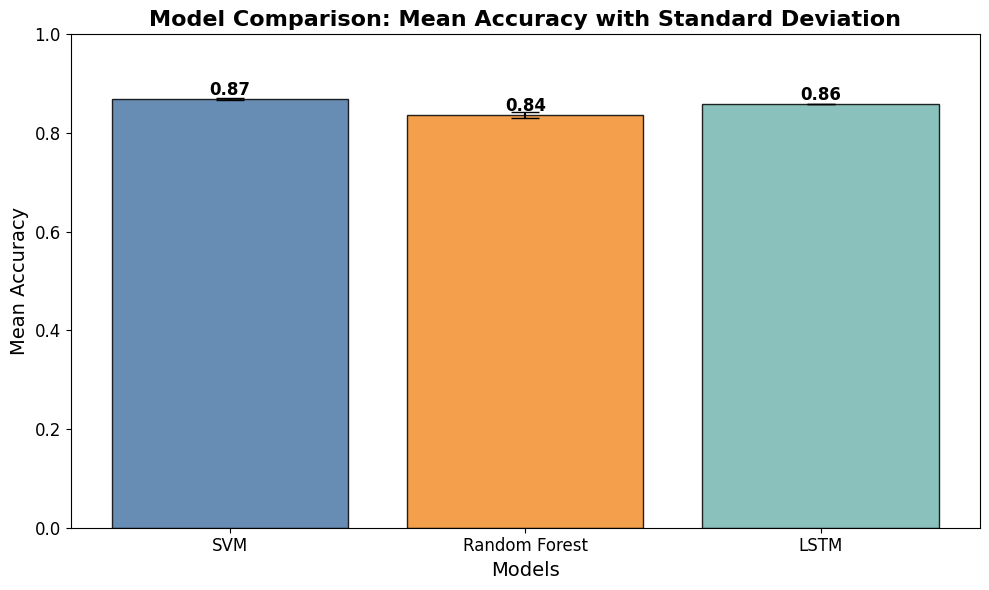

In [104]:
# Plot results from each model and compare them
models = ['SVM', 'Random Forest', 'LSTM']
accuracies = [svm_results['mean_accuracy'], rf_results['mean_accuracy'], accuracy]
stds = [svm_results['std_accuracy'], rf_results['std_accuracy'], 0]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(
    models,
    accuracies,
    yerr=stds,
    capsize=10,
    color=['#4E79A7', '#F28E2B', '#76B7B2'],  # Improved color scheme
    alpha=0.85,
    edgecolor='black'
)

# Annotate bars with accuracy values
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{bar.get_height():.2f}',
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

# Titles and Labels
plt.title('Model Comparison: Mean Accuracy with Standard Deviation', fontsize=16, fontweight='bold')
plt.ylabel('Mean Accuracy', fontsize=14)
plt.xlabel('Models', fontsize=14)
plt.ylim(0, 1)  # Ensure y-axis covers full range
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout and display
plt.tight_layout()
plt.show()


SVM takes the lead in the area of mean accuracy (with standard deviation) with a mere 1% difference from the LSTM model. 

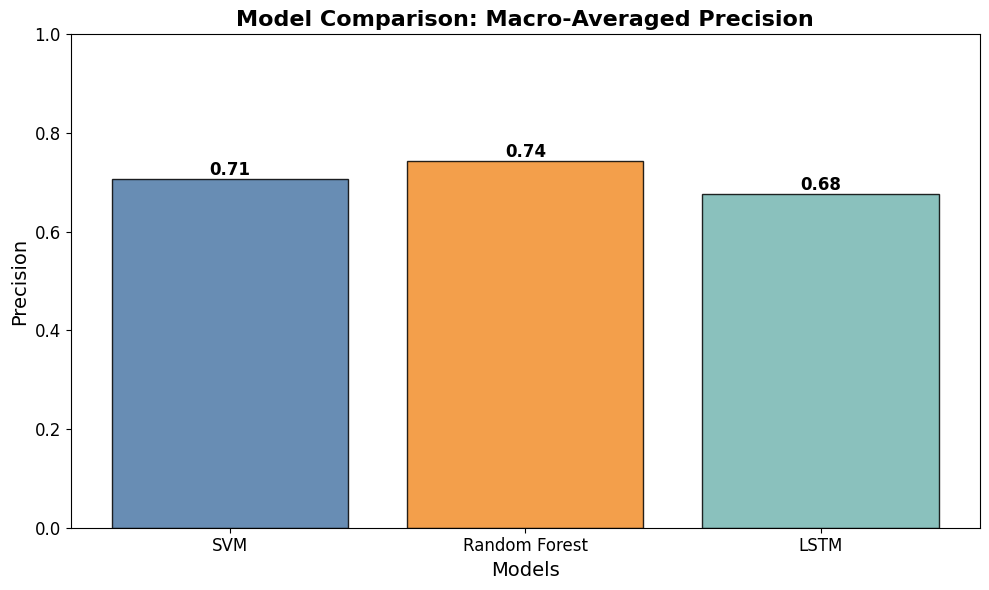

In [ ]:
# Compare model performance for each class
svm_reports_df = pd.DataFrame([report['macro avg'] for report in svm_reports])  # Convert SVM reports to a DataFrame
rf_reports_df = pd.DataFrame([report['macro avg'] for report in rf_reports])    # Convert RF reports to a DataFrame

# Extract precision scores
svm_class_reports = svm_reports_df['precision'].mean()
rf_class_reports = rf_reports_df['precision'].mean()
lstm_class_report = classification_report(y_test, y_pred, output_dict=True)['macro avg']['precision']

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(
    ['SVM', 'Random Forest', 'LSTM'],
    [svm_class_reports, rf_class_reports, lstm_class_report],
    color=['#4E79A7', '#F28E2B', '#76B7B2'],
    alpha=0.85,
    edgecolor='black'
)

# Annotate bars with precision values
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{bar.get_height():.2f}',
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

# Titles and Labels
plt.title('Model Comparison: Macro-Averaged Precision', fontsize=16, fontweight='bold')
plt.ylabel('Precision', fontsize=14)
plt.xlabel('Models', fontsize=14)
plt.ylim(0, 1)  # Ensure y-axis covers full precision range
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout and display
plt.tight_layout()
plt.show()


Precision (the ratio of correctly predicted positive observations to the total predicted positives) sees its highest value in the Random Forest model, this could suggest a more conservative approach to predicting hate speech and offensive language. This however comes at the cost of a lower recall compared to the other models.

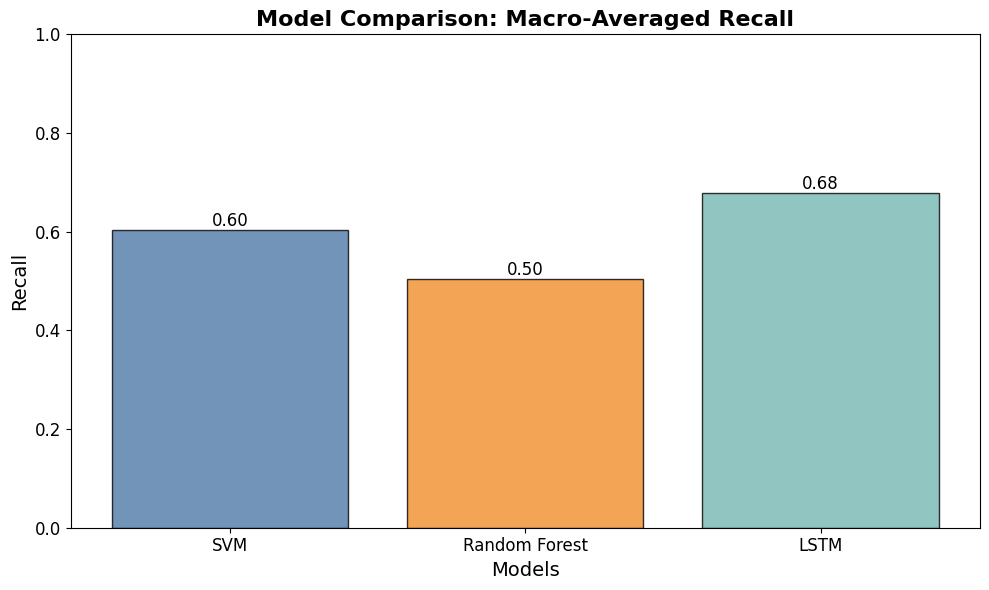

In [99]:
# Compare recall and F1-score for each class
svm_class_reports = svm_reports_df['recall'].mean()
rf_class_reports = rf_reports_df['recall'].mean()
lstm_class_report = classification_report(y_test, y_pred, output_dict=True)['macro avg']['recall']

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(
    ['SVM', 'Random Forest', 'LSTM'],
    [svm_class_reports, rf_class_reports, lstm_class_report],
    color=['#4E79A7', '#F28E2B', '#76B7B2'],
    alpha=0.8,
    edgecolor='black'
)

# Annotating the bars with their heights
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{bar.get_height():.2f}',
        ha='center',
        va='bottom',
        fontsize=12
    )

# Title and labels
plt.title('Model Comparison: Macro-Averaged Recall', fontsize=16, fontweight='bold')
plt.ylabel('Recall', fontsize=14)
plt.xlabel('Models', fontsize=14)
plt.ylim(0, 1)  # Ensure y-axis covers full recall range
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.tight_layout()
plt.show()


LSTM performs best in terms of recall (the ratio of correctly predicted positive observations to the all observations in actual class). With the nature of the model, it is able to keep a good balance between false negatives and false positives. This reflects the strength of the LSTM model in capturing the sequential nature of the tweets. This byb proxy also gives the LSTM model the highest F1 score.

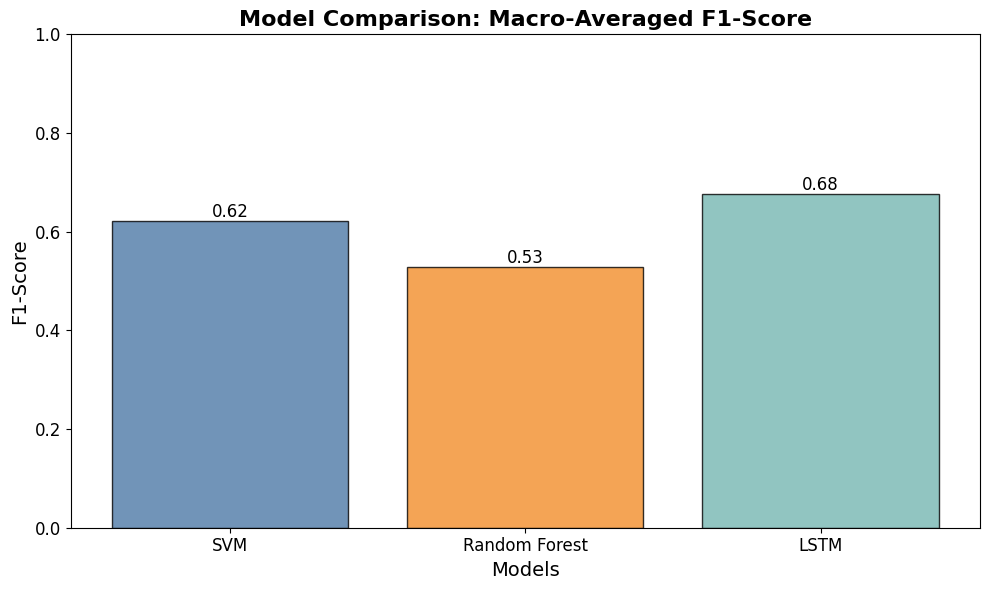

In [100]:
# Compare F1-score for each class
svm_class_reports = svm_reports_df['f1-score'].mean()
rf_class_reports = rf_reports_df['f1-score'].mean()
lstm_class_report = classification_report(y_test, y_pred, output_dict=True)['macro avg']['f1-score']

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(
    ['SVM', 'Random Forest', 'LSTM'],
    [svm_class_reports, rf_class_reports, lstm_class_report],
    color=['#4E79A7', '#F28E2B', '#76B7B2'],
    alpha=0.8,
    edgecolor='black'
)

# Annotating the bars with their heights
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{bar.get_height():.2f}',
        ha='center',
        va='bottom',
        fontsize=12
    )

# Title and labels
plt.title('Model Comparison: Macro-Averaged F1-Score', fontsize=16, fontweight='bold')
plt.ylabel('F1-Score', fontsize=14)
plt.xlabel('Models', fontsize=14)
plt.ylim(0, 1)  # Ensure y-axis covers full F1-score range
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.tight_layout()

## 5. References
- Abid Hussain Wani, Nahida Shafi Molvi and Sheikh Ishrah Ashraf (2019). Detection of Hate and Offensive Speech in Text. Intelligent Human Computer Interaction, pp.87–93. doi:https://doi.org/10.1007/978-3-030-44689-5_8.
- Davidson, T., Warmsley, D., Macy, M. and Weber, I. (2017). Automated Hate Speech Detection and the Problem of Offensive Language. Proceedings of the International AAAI Conference on Web and Social Media, 11(1), pp.512–515. doi:https://doi.org/10.1609/icwsm.v11i1.14955.
- Sanh, V., Debut, L., Chaumond, J. and Wolf, T. (2020). DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter. [online] Available at: https://arxiv.org/pdf/1910.01108.
- Watanabe, H., Bouazizi, M. and Ohtsuki, T. (2018). Hate Speech on Twitter: A Pragmatic Approach to Collect Hateful and Offensive Expressions and Perform Hate Speech Detection. IEEE Access, 6, pp.13825–13835. doi:https://doi.org/10.1109/access.2018.2806394.